In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import scipy as sp
from sklearn.model_selection import train_test_split

In [2]:
import re, string

In [3]:
!pip install datasets

In [4]:
from datasets import Dataset

In [5]:
!pip install stopwordsiso

In [6]:
import stopwordsiso
from stopwordsiso import stopwords

In [7]:
df = pd.read_csv('test.csv', encoding='gb18030')

In [8]:
df.head()

,news,category
0,1988-2018，116所小学从南京消失了,2
1,Facebook重组为三大主要部门 区块链集团显现,4
2,韩瑜出席活动 网友：好羡慕这个肌肉男，有种想去健身的冲动,8
3,做事情、干工作的五种境界，亲爱的，您处于哪一种境界？,2
4,这个世界不只有几个名人,4


In [9]:
df.shape

(10000, 2)

In [10]:
df['category'].value_counts()

category
8    1032
5    1026
9    1023
4    1004
1     994
6     991
7     988
0     986
2     983
3     973
Name: count, dtype: int64

Finance 0

Real estate 1

Education 2

Military 3

Technology 4

Cars 5

Sports 6

Games 7

Entertainment 8

Others 9

In [11]:
def preprocess(text):
    text = text.strip()  #get rid of leading/trailing whitespace
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

    return text

In [12]:
for i in range(df.shape[0]):
  df['news'][i] = preprocess(df['news'][i])

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-12-aea7f1cccd4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = preprocess(df['news'][i])
<ipython-input-12-aea7f1cccd4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = preprocess(df['news'][i])
<ipython-input-12-aea7f1cccd4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = preprocess(df['news'][i])
<i

In [13]:
def stopword_clear(string):
    a = [i for i in string.split() if i not in stopwords(["zh"])]
    return ' '.join(a)

In [14]:
for i in range(df.shape[0]):
  df['news'][i] = stopword_clear(df['news'][i])

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-14-d7f423fe13db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = stopword_clear(df['news'][i])
<ipython-input-14-d7f423fe13db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = stopword_clear(df['news'][i])
<ipython-input-14-d7f423fe13db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'][i] = stopword_clear(df['n

In [15]:
df.head()

,news,category
0,所小学从南京消失了,2
1,facebook重组为三大主要部门 区块链集团显现,4
2,韩瑜出席活动 网友好羡慕这个肌肉男有种想去健身的冲动,8
3,做事情干工作的五种境界亲爱的您处于哪一种境界,2
4,这个世界不只有几个名人,4


In [16]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['news', 'category']])
small_dataset = dataset.shuffle(seed=42).select(range(2000))

In [17]:
# Split the dataset into train and test
small_dataset = small_dataset.train_test_split(test_size=0.2)
train_dataset = small_dataset['train']
test_dataset = small_dataset['test']

In [18]:
train_dataset

Dataset({
    features: ['news', 'category'],
    num_rows: 1600
})

In [19]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="iioSnail/bert-base-chinese-word-classifier")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("iioSnail/bert-base-chinese-word-classifier")
model = TFAutoModelForSequenceClassification.from_pretrained("iioSnail/bert-base-chinese-word-classifier")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [21]:
tokenized_data = tokenizer(train_dataset["news"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_data = dict(tokenized_data)

labels = np.array(train_dataset["category"])  # Label is already an array of 0 and 1

In [22]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][1])
tokens

['[CLS]',
 '王',
 '者',
 '荣',
 '耀',
 '英',
 '雄',
 '撞',
 '脸',
 '明',
 '星',
 '吴',
 '亦',
 '凡',
 '和',
 '达',
 '摩',
 '亲',
 '兄',
 '弟',
 '不',
 '知',
 '火',
 '舞',
 '好',
 '胸',
 '怀',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [23]:
tokenized_data

{'input_ids': array([[ 101,  872, 4685, ...,    0,    0,    0],
        [ 101, 4374, 5442, ...,    0,    0,    0],
        [ 101, 1417, 5277, ...,    0,    0,    0],
        ...,
        [ 101, 2207,  832, ...,    0,    0,    0],
        [ 101,  872, 1762, ...,    0,    0,    0],
        [ 101, 2405, 1036, ...,    0,    0,    0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])}

In [24]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers

In [25]:
model.compile(optimizer='adadelta', metrics=['accuracy'])

In [26]:
history = model.fit(tokenized_data, labels, epochs=30)

Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - 98s 302ms/step - loss: 6.5499 - accuracy: 0.0712
Epoch 2/30
50/50 [==============================] - 15s 307ms/step - loss: 5.5697 - accuracy: 0.0750
Epoch 3/30
50/50 [==============================] - 15s 307ms/step - loss: 4.8814 - accuracy: 0.0919
Epoch 4/30
50/50 [==============================] - 16s 312ms/step - loss: 4.3454 - accuracy: 0.0900
Epoch 5/30
50/50 [==============================] - 16s 313ms/step - loss: 3.9181 - accuracy: 0.1106
Epoch 6/30
50/50 [==============================] - 16s 311ms/step - loss: 3.6517 - accuracy: 0.1244
Epoch 7/30
50/50 [==============================] - 15s 309ms/step - loss: 3.3815 - accuracy: 0.1506
Epoch 8/30
50/50 [==============================] - 15s 308ms/step - loss: 3.2310 - accuracy: 0.1688
Epoch 9/30
50/50 [==============================] - 16s 312ms/ste

In [27]:
tokenized_input = tokenizer(test_dataset["news"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_input = dict(tokenized_input)

In [28]:
#Predict y value for test dataset
y_predict = model.predict(tokenized_input)


13/13 [==============================] - 9s 92ms/step


In [47]:
type(y_predict)

transformers.modeling_tf_outputs.TFSequenceClassifierOutput

Finance 0

Real estate 1

Education 2

Military 3

Technology 4

Cars 5

Sports 6

Games 7

Entertainment 8

Others 9

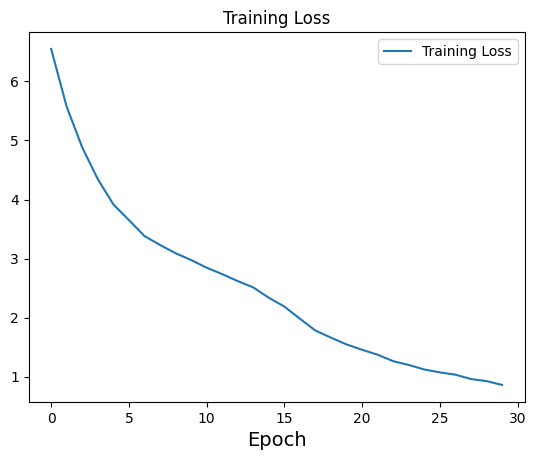

In [45]:
plt.plot(np.arange(0, 30), history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch', size=14)
plt.legend();

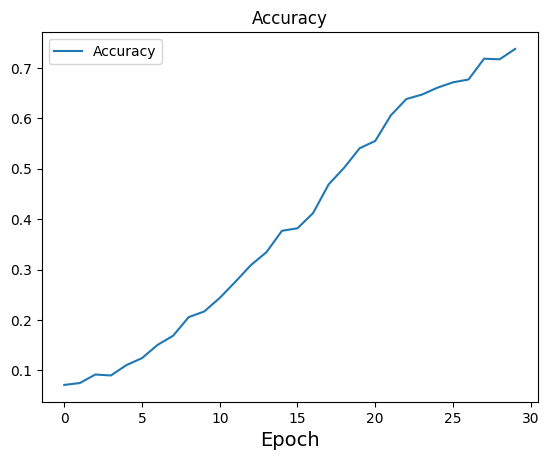

In [44]:
plt.plot(np.arange(0, 30), history.history['accuracy'], label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch', size=14)
plt.legend();

In [48]:
test_dataset

Dataset({
    features: ['news', 'category'],
    num_rows: 400
})

In [51]:
tokenized_input = tokenizer(test_dataset["news"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_input = dict(tokenized_input)

test_labels = np.array(test_dataset["category"])  # Label is already an array of 0 and 1

In [52]:
loss, accuracy = model.evaluate(tokenized_input, test_labels)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


13/13 [==============================] - 22s 108ms/step - loss: 1.2636 - accuracy: 0.6300
Test Loss: 1.2635871171951294
Test Accuracy: 0.6299999952316284
